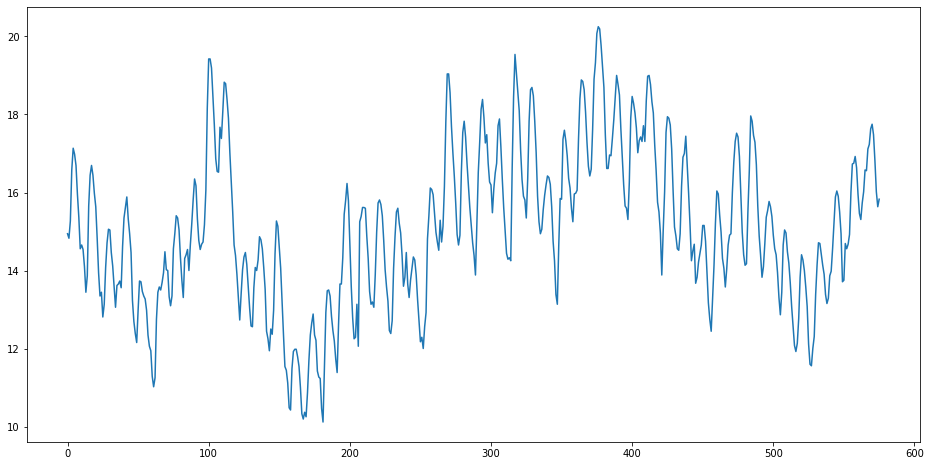

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import acf
import statsmodels.api as sm
from pmdarima import auto_arima
from statsmodels.graphics.tsaplots import plot_acf
from project_utils import fourier_extrapolation
from scipy.stats import jarque_bera
from statsmodels.stats.diagnostic import acorr_ljungbox

%matplotlib inline
plt.rcParams["figure.figsize"] = (16,8)
df = pd.read_csv('data/hyd_post.txt', index_col=0)
hyd = np.array(df.x)


plt.plot(hyd)

/home/travis/myVenv/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:572: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  FutureWarning


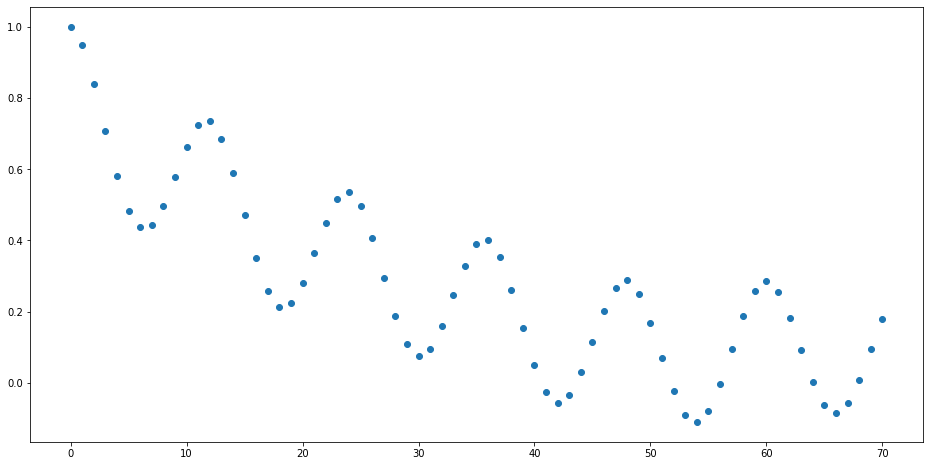

In [2]:
plt.plot(acf(hyd, nlags= 70),'o')

/home/travis/myVenv/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in true_divide
  


,power,freq
1,157961.328850,576.0
575,157961.328850,-576.0
48,135897.051215,12.0
528,135897.051215,-12.0
6,93175.965811,96.0
570,93175.965811,-96.0
2,90376.430883,288.0
574,90376.430883,-288.0
572,44569.612561,-144.0
4,44569.612561,144.0


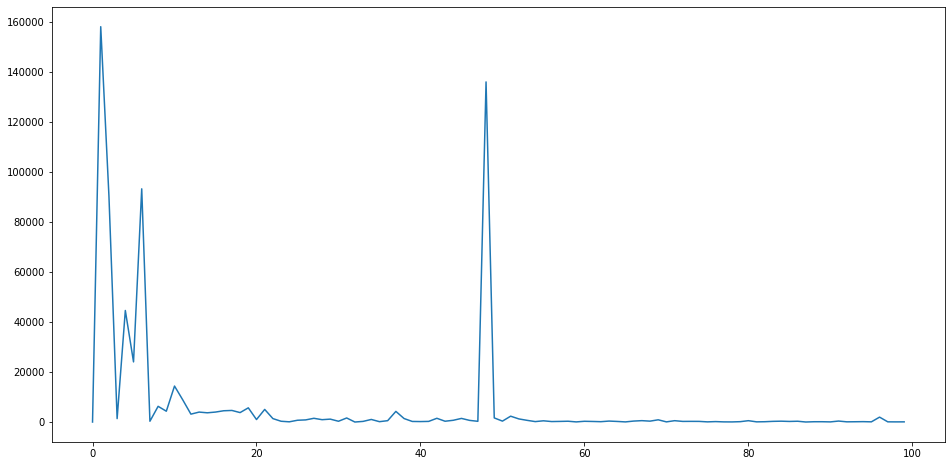

In [3]:
fourier_coeff = np.fft.fft(hyd-hyd.mean())
per = 1/np.fft.fftfreq(len(hyd))
powers = np.abs(fourier_coeff)**2
plt.plot((np.abs(fourier_coeff)**2)[:100])
n = list(range(len(powers)))
pd.DataFrame({'power': powers, 'freq':per}).sort_values('power', ascending=False).head(12)

In [4]:
from tbats import TBATS, BATS
# Fit the model
estimator = TBATS(seasonal_periods=(12, 96))
model = estimator.fit(hyd)
# Forecast 24 months ahead
y_forecast = model.forecast(steps=24)

In [5]:
print(model.summary())

Use Box-Cox: False
Use trend: True
Use damped trend: True
Seasonal periods: [12. 96.]
Seasonal harmonics [5 1]
ARMA errors (p, q): (0, 0)
Smoothing (Alpha): 1.211743
Trend (Beta): -0.085367
Damping Parameter (Phi): 0.899682
Seasonal Parameters (Gamma): [-5.55870235e-07  7.61725521e-07  6.61576802e-07 -2.27386211e-07]
AR coefficients []
MA coefficients []
Seed vector [ 1.44045563e+01 -1.52137271e-02 -1.22558046e+00  4.11467983e-02
  1.15260408e-01  6.26001809e-02 -1.36888215e-03  3.65327353e-01
 -1.44447968e-01 -6.23064437e-02  7.58316439e-03  1.81183879e-02
  1.03919996e+00  5.53647766e-01]

AIC 2639.054599


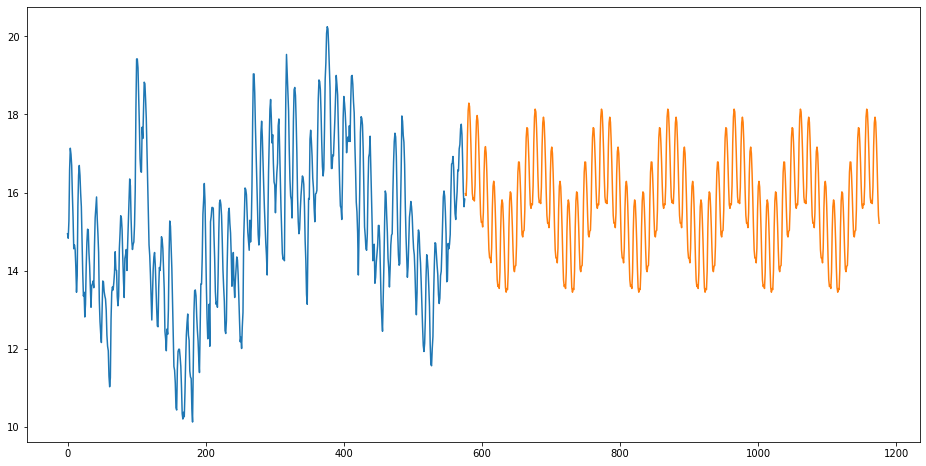

In [6]:
y_forecast = model.forecast(steps=600)
forecast = np.concatenate([np.array([float('nan')]*len(hyd)), y_forecast])
plt.plot(hyd)
plt.plot(forecast)

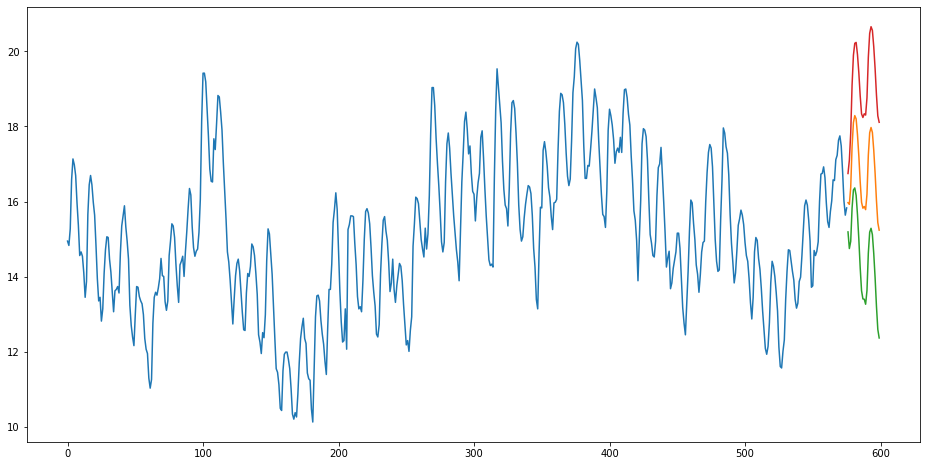

In [7]:
y_forecast = model.forecast(steps=24, confidence_level=0.95)[1]
forecast_mean = np.concatenate([np.array([float('nan')]*len(hyd)), y_forecast['mean']])
forecast_ub = np.concatenate([np.array([float('nan')]*len(hyd)), y_forecast['upper_bound']])
forecast_lb = np.concatenate([np.array([float('nan')]*len(hyd)), y_forecast['lower_bound']])
plt.plot(hyd)
plt.plot(forecast_mean)
plt.plot(forecast_lb)

plt.plot(forecast_ub)

-1


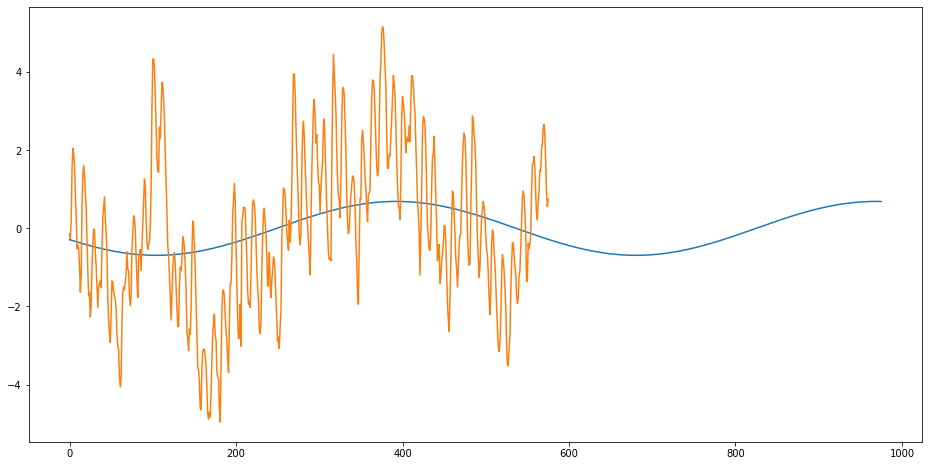

In [8]:
cut_off = np.percentile(powers, 95)
thresh_coeff = fourier_coeff.copy()
pick = -1-n.pop(0)
thresh_coeff[powers<powers[powers.argsort()[pick]]] = 0
filtered_hyd = np.real(np.fft.ifft(thresh_coeff))
w_extrap = np.concatenate([filtered_hyd,fourier_extrapolation(thresh_coeff, 400)])
plt.plot(w_extrap)
plt.plot(hyd-hyd.mean())
print(pick)

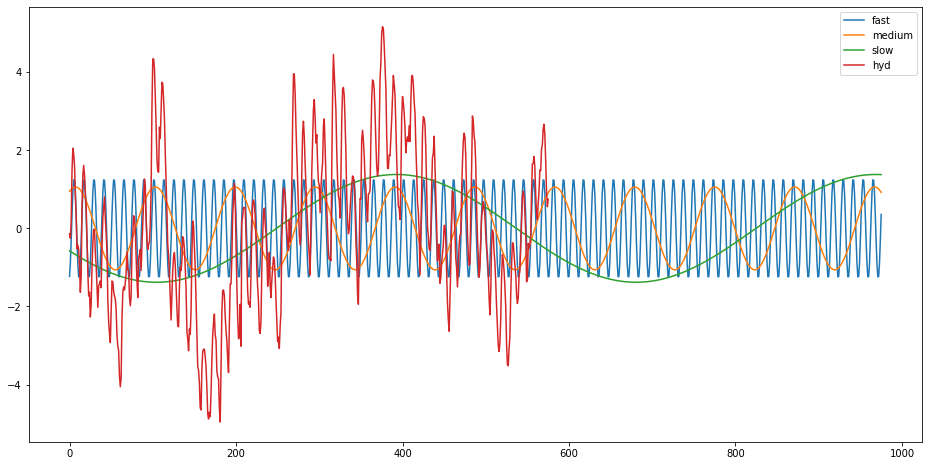

In [9]:
slow = [-1,-2]
fast = [-3, -4]
medium = [-5, -6]

def thresh_coeffs(lower, upper, coeffs):
    powers = np.abs(coeffs)**2
    thresh_coeff = coeffs.copy()
    thresh_coeff[powers>powers[powers.argsort()[  upper]]] = 0
    thresh_coeff[powers<powers[powers.argsort()[ lower]]] = 0
    return thresh_coeff

extrap_size = 400

new_coeffs = thresh_coeffs(fast[1], fast[0], fourier_coeff)
filtered_hyd = np.real(np.fft.ifft(new_coeffs))
fast = np.concatenate([filtered_hyd,fourier_extrapolation(new_coeffs, extrap_size)])

new_coeffs = thresh_coeffs(slow[1], slow[0], fourier_coeff)
filtered_hyd = np.real(np.fft.ifft(new_coeffs))
slow = np.concatenate([filtered_hyd,fourier_extrapolation(new_coeffs, extrap_size)])

new_coeffs = thresh_coeffs(medium[1], medium[0], fourier_coeff)
filtered_hyd = np.real(np.fft.ifft(new_coeffs))
medium = np.concatenate([filtered_hyd,fourier_extrapolation(new_coeffs, extrap_size)])
total_df =pd.DataFrame({'fast':fast, 'medium':medium, 'slow':slow, 
                     'hyd': np.concatenate([hyd-hyd.mean(), np.array(extrap_size*[float('nan')])])})
total_df.plot()
exog = pd.DataFrame({'fast':fast, 'medium':medium, 'slow':slow})
exog_to_train  = exog.iloc[:len(hyd)]
exog_to_test = exog.iloc[len(hyd):]

/home/travis/myVenv/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  576
Model:               SARIMAX(1, 0, 1)   Log Likelihood                -334.243
Date:                Tue, 02 Jun 2020   AIC                            682.486
Time:                        04:43:17   BIC                            712.979
Sample:                             0   HQIC                           694.378
                                - 576                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      1.2639      0.270      4.681      0.000       0.735       1.793
fast           0.9982      0.053     18.793      0.000       0.894       1.102
medium         1.0554      0.312      3.386      0.001       0.445       1.666
slow           0.9707      0.272      3.574      0.000       0.438       1.503
ar.L1          0.9164      0.018     51.407      0.000       0.882       0.951
ma.L1          0.2268      0.032      7.020      0.000       0.163       0.290
sigma2         0.1861      0.008     24.589      0.000       0.171       0.201
===================================================================================
Ljung-Box (Q):                      114.88   Jarque-Bera (JB):               405.65
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.77   Skew:                             0.70
Prob(H) (two-sided):                  0.07   Kurtosis:                         6.87
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

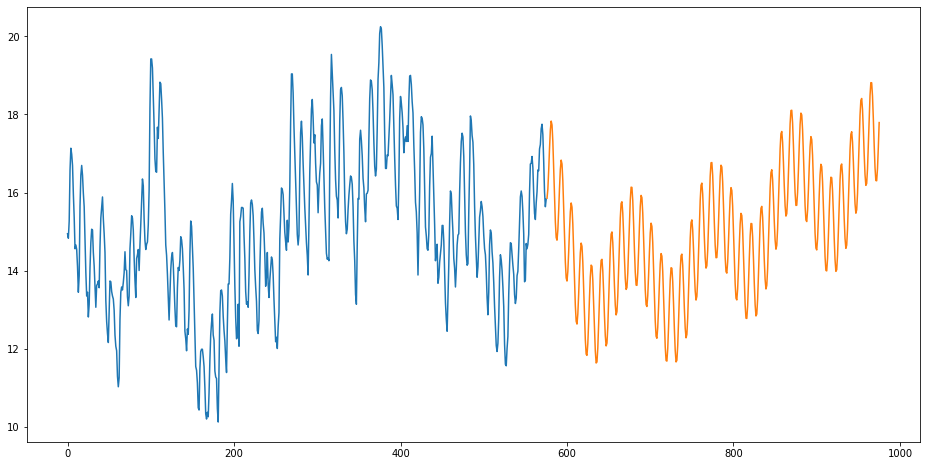

In [10]:
# All waves.
arima_exog_model = auto_arima(y=hyd, exogenous=exog_to_train, seasonal=False)
# Forecast
y_arima_exog_forecast = arima_exog_model.predict(n_periods=extrap_size, exogenous=exog_to_test)
forecast = np.concatenate([np.array([float('nan')]*len(hyd)), y_arima_exog_forecast])
plt.plot(hyd)
plt.plot(forecast)
arima_exog_model.summary()

In [ ]:
# All waves. and Seasonal arima
arima_exog_model1 = auto_arima(y=hyd, exogenous=exog_to_train, seasonal=True, m=12)
# Forecast
y_arima_exog_forecast1 = arima_exog_model1.predict(n_periods=extrap_size, exogenous=exog_to_test)
forecast = np.concatenate([np.array([float('nan')]*len(hyd)), y_arima_exog_forecast1])
plt.plot(hyd)
plt.plot(forecast)
arima_exog_model1.summary()

/home/travis/myVenv/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/travis/myVenv/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [ ]:
# med and slow term waves. and Seasonal arima for the fast 
arima_exog_model2 = auto_arima(y=hyd, exogenous=exog_to_train[['slow', 'medium']], seasonal=True, m=12)
# Forecast
y_arima_exog_forecast2 = arima_exog_model2.predict(n_periods=extrap_size, exogenous=exog_to_test[['slow', 'medium']])
forecast = np.concatenate([np.array([float('nan')]*len(hyd)), y_arima_exog_forecast2])
plt.plot(hyd)
plt.plot(forecast)

In [ ]:
arima_exog_model2.summary()

In [ ]:
# medium wave only
arima_exog_model3 = auto_arima(y=hyd, exogenous=exog_to_train[['medium']], seasonal=True, m=12)
# Forecast

y_arima_exog_forecast3 = arima_exog_model3.predict(n_periods=extrap_size, exogenous=exog_to_test[['medium']])

forecast = np.concatenate([np.array([float('nan')]*len(hyd)), y_arima_exog_forecast3])
plt.plot(hyd)
plt.plot(forecast)

In [ ]:
arima_exog_model3.summary()

In [ ]:
final_forecast = arima_exog_model3.predict(n_periods=24, exogenous=exog_to_test[['medium']][:24], return_conf_int=True, alpha=0.05)

ci_s = pd.DataFrame(final_forecast[1], columns=['lower', 'upper'], index=exog_to_test.index[:24])


simultanious_ub = np.zeros(24)
simultanious_lb = np.zeros(24)

for i in range(24):
    fore = arima_exog_model3.predict(n_periods=24, exogenous=exog_to_test[['medium']][:24], return_conf_int=True, alpha=0.05/(i+1))
    
    simultanious_lb[i] = fore[1][i, 0]
    simultanious_ub[i] = fore[1][i, 1]
    
    
simultanious = pd.DataFrame({'simultanious_lb': simultanious_lb, 'simultanious_ub': simultanious_ub},index=exog_to_test.index[:24])


In [ ]:
forecast = pd.DataFrame(final_forecast[0], columns=['hyd_forecast'], index=exog_to_test.index[:24])

sarima_df = pd.concat([pd.Series(hyd, name='hyd'), forecast, ci_s,simultanious ], axis=1)
sarima_df.plot()

In [ ]:
forecast.to_csv('Dunn_Scenario1_raw.csv')